In this notebook, we'll be implementing the LBFGS method in pytorch

Now we will use a PINN to solve the inverse problem.

The differential equation we will be solving is:
$$
\frac{df}{dt} = R(t)(1-t)t
$$

R is a time varying parameter. We will use a NN to figure it out

$R(t)$ will be 

$$
2 \quad \textrm{when} \quad t<3 \\
-1 \quad \textrm{when} \quad t\ge3
$$

The initial condition will be

$$
f(0) = 1
$$

The true solution to this equation looks is:
    
$$
f = 1 -2\frac{t^3}{3}+2\frac{t^2}{2} \quad \textrm{when}  \quad  t<3 \\
f = -12.5+\frac{t^3}{3}+-\frac{t^2}{2} \quad \textrm{when} \quad  t\ge3
$$
   
which looks like this:


# Libraries

In [36]:
from scipy import integrate as inte
import numpy as np
import matplotlib.pyplot as plt
import do_mpc
from casadi import *
from matplotlib.animation import FuncAnimation
import numpy as np
from torch import nn
import torch
from torch.optim import Adam
import matplotlib.pyplot as plt
import itertools

# Setting up model and testing it

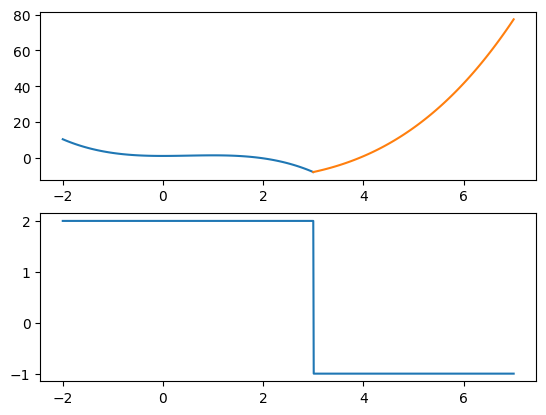

In [37]:
# Data generation
def f_true(t,r,f):
    return f-r*t**3 / 3 + r*t**2/2

def r_true(t_vec):
    return [-1 if t>3 else 2 for t in t_vec]

fig,ax = plt.subplots(2,1)
t_data_max = np.linspace(-2,3,100)
ax[0].plot(t_data_max,f_true(t_data_max,2,1))
t_data_max = np.linspace(3,7,100)
ax[0].plot(t_data_max,f_true(t_data_max,-1,-12.5))

t_data_max = np.linspace(-2,7,1000)
ax[1].plot(t_data_max,r_true(t_data_max))

In [38]:
# Data generation
def f_true(t,r,f):
    return f-r*t**3 / 3 + r*t**2/2

In [39]:
N = 10
R = 2
F0 = 1
t_data1 = torch.linspace(-1, 2, steps=N,requires_grad = True).view(-1, 1)
t_data2 = torch.linspace(4, 6, steps=N,requires_grad = True).view(-1, 1)
t_data = torch.concatenate((t_data1,t_data2))

In [40]:

f_data = []
for i in range(len(t_data)):
    t = t_data[i].detach().numpy()
    if t<3:
        R = 2
        F0 = 1
    else:
        R = -1
        F0 = -12.5
    f_data.append( f_true(t , R, F0) )

f_data_tensor = torch.as_tensor(f_data)

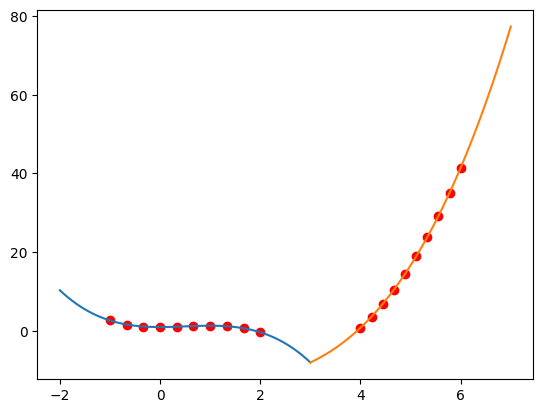

In [41]:
t_data_max = np.linspace(-2,3,100)
plt.plot(t_data.detach().numpy(),f_data,'or')
plt.plot(t_data_max,f_true(t_data_max,2,1))
t_data_max = np.linspace(3,7,100)
plt.plot(t_data_max,f_true(t_data_max,-1,-12.5))

In [42]:
class NNapproximator(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh()):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out

PINN = NNapproximator(2,2)

In [43]:
class Rapproximator(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh()):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out
    
Rapprox = Rapproximator(2,3)

In [44]:
# This is the forward function
def f(nn, x):
    return nn(x)

# This is the forward derivative function
def df(nn,x,order = 1):
    df_value = f(nn,x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs = torch.ones_like(x),
            create_graph = True,
            retain_graph = True
        )[0]
    return df_value

def compute_loss(nn,rr,x):
    de_loss = df(nn,x) - rr(x)*x*(1-x)
    bc_loss = f(nn,t_data) - f_data_tensor
    final_loss = de_loss.pow(2).mean() + bc_loss.pow(2).mean()
    return final_loss


In [53]:
lr = 0.1
epochs = 100000
PINN = NNapproximator(2,10)
R_approx = Rapproximator(2,3)
learnable_params = list(PINN.parameters()) + list(R_approx.parameters())


optimizer = torch.optim.LBFGS(learnable_params, 
                              history_size=50, 
                              max_iter=20,
                              lr = lr,
                              line_search_fn="strong_wolfe")

# Need a closure function for LFBGS
def closure():
    optimizer.zero_grad()
    loss = compute_loss(PINN,R_approx,t_data)
    loss.backward()
    return loss

history_lbfgs = []
for i in range(200):
    loss = compute_loss(PINN,R_approx,t_data)
    history_lbfgs.append(loss.item())
    optimizer.step(closure)


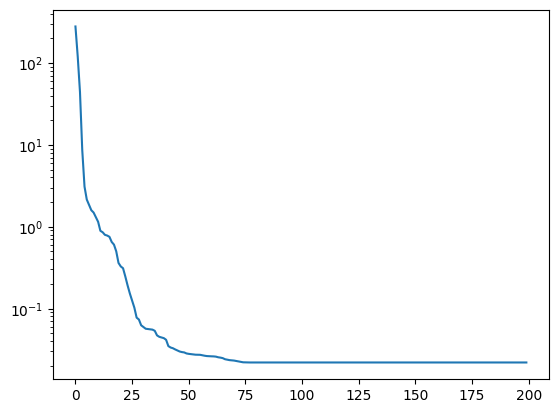

In [54]:
plt.plot(history_lbfgs)
plt.yscale("log")

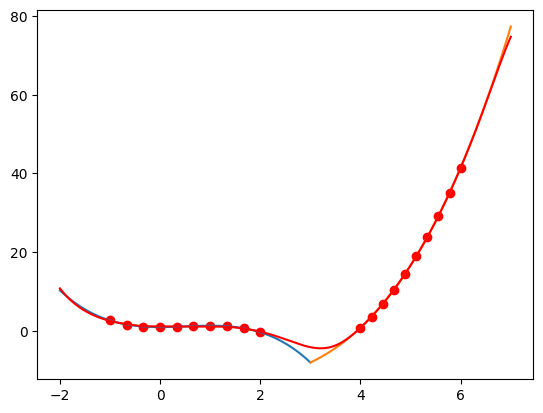

In [55]:
t_data_domain = torch.linspace(-2, 7, steps=1000).view(-1, 1)
with torch.no_grad():
    f_prediction = PINN(t_data_domain).numpy()
    

plt.plot(t_data.detach().numpy(),f_data,'or')

t_data_max = np.linspace(-2,3,100)
plt.plot(t_data_max,f_true(t_data_max,2,1))
t_data_max = np.linspace(3,7,100)
plt.plot(t_data_max,f_true(t_data_max,-1,-12.5))
plt.plot(t_data_domain,f_prediction,'r')

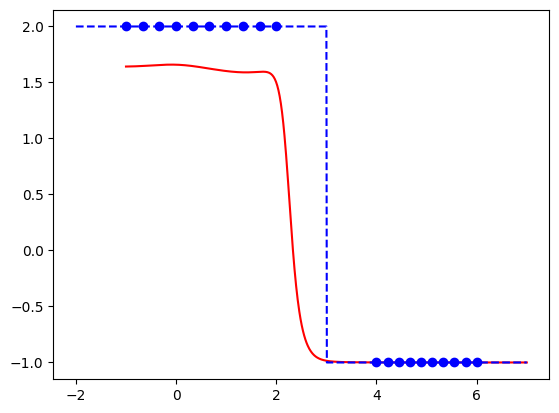

In [56]:
# NOw interrogate the R approximator
t_data_domain = torch.linspace(-1, 7, steps=1000).view(-1, 1)
with torch.no_grad():
    r_prediction = R_approx(t_data_domain).numpy()

plt.plot(t_data_domain,r_prediction,'r')
t_data_max = np.linspace(-2,7,1000)
plt.plot(t_data_max,r_true(t_data_max),'b--')
points_sampled = t_data.flatten().detach().numpy()
plt.plot(points_sampled,r_true(points_sampled),'bo')